In [1]:
import numpy as np
import cv2
import torch

In [2]:
from functions import show_tensor

### Select device

In [3]:
device = torch.device("cuda")

### Create default or your own generator and EMA generator

In [ ]:
from generator import define_G

def make_generator():
    gen = define_G(input_nc = 3, output_nc = 3, ngf = 64, netG = "global", norm = "instance", n_downsample_global = 3, n_blocks_global = 9, n_local_enhancers = 1, n_blocks_local = 3).to(device)
    return gen
generator = make_generator()
generator_ema = make_generator()

# Initilalize generators with equal parameters
with torch.no_grad():
    for (gp, ep) in zip(generator.parameters(), generator_ema.parameters()):
        ep.data = gp.data.detach()

### Use the default or your own discriminator

In [ ]:
from discriminator import define_D

discriminator = define_D(input_nc = 3 + 3, ndf = 64, n_layers_D = 3, num_D = 3, norm="instance", getIntermFeat=True).to(device)

In [7]:
import losses
criterionGAN = losses.GANLoss(use_lsgan=True).to(device)
criterionFeat = torch.nn.L1Loss().to(device)
criterionVGG = losses.VGGLoss().to(device)

In [8]:
from replay_pool import ReplayPool
replay_pool = ReplayPool(10)

In [9]:
G_optim = torch.optim.AdamW(generator.parameters(), lr=1e-4)
D_optim = torch.optim.AdamW(discriminator.parameters(), lr=1e-4)

### Modify the dataset class for your requirements

In [10]:
from torchvision import transforms
from random import uniform, randint
from glob import glob
import os

class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, images_dir):

        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.imagesDir = images_dir
        self.images = glob(images_dir + "*.jpg")

        
    def __getitem__(self, idx):
        from random import random, randint, uniform
        f_name = self.images[idx]

        pair = cv2.imread(f_name, 1)
        pair = cv2.cvtColor(pair, cv2.COLOR_BGR2RGB)
        mid = pair.shape[1]//2
        dst = pair[:, :mid]
        src = pair[:, mid:]
        
        w = 256
        h = 256

        if random() < 0.5:
            src = np.fliplr(src)
            dst = np.fliplr(dst)

        src_tensor = self.to_tensor(src.copy())
        dst_tensor = self.to_tensor(dst.copy())
        return src_tensor, dst_tensor
        
    def __len__(self):
        return len(self.images)
        

In [11]:
batch_size = 8
train_dataset = Dataset("./data/facades/train/")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, num_workers=4, shuffle=True)
test_dataset = Dataset("./data/facades/val/")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, num_workers=4, shuffle=True)

In [12]:
data, targets = next(iter(train_loader))

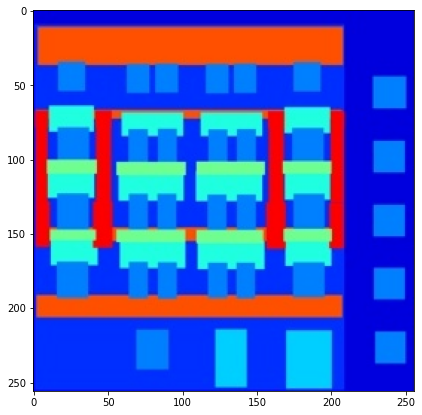

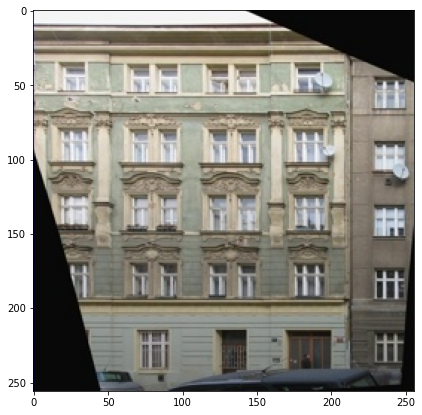

In [13]:
show_tensor(data[0])
show_tensor(targets[0])

In [14]:
checkpoint_dir = "./checkpoints/facades/"
images_output_dir = os.path.join(checkpoint_dir, "images")
if not os.path.exists(images_output_dir):
    os.makedirs(images_output_dir)

In [15]:
import os
def test(epoch, iteration):
    with torch.no_grad():
        data, target = next(iter(test_loader)) 
        data = data.to(device)
        generator_ema.eval()
        out = generator_ema(data)
        generator_ema.train()
        matrix = []
        pairs = torch.cat([data, out, target.to(device)], -1)
        for idx in range(data.shape[0]):
            img = 255*(pairs[idx] + 1)/2
            img = img.cpu().permute(1, 2, 0).clip(0, 255).numpy().astype(np.uint8)
            matrix.append(img)
        matrix = np.vstack(matrix)
        matrix = cv2.cvtColor(matrix, cv2.COLOR_RGB2BGR)
        out_file = os.path.join(images_output_dir, f"{epoch}_{iteration}.jpg")
        cv2.imwrite(out_file, matrix)
    

In [16]:
from moving_average import moving_average
from tqdm import tqdm

def process_loss(log, losses):
    loss = 0
    for k in losses:
        if k not in log:
            log[k] = 0
        log[k] += losses[k].item()
        loss = loss + losses[k]
    return loss

def calc_G_losses(data, target):
    fake = generator(data)
    loss_vgg = 1*criterionVGG(fake, target)
    pred_fake = discriminator(torch.cat([data, fake], axis=1))
    loss_adv = 1*criterionGAN(pred_fake, 1)

    with torch.no_grad():
        pred_true = discriminator(torch.cat([data, target], axis=1))

    loss_adv_feat = 0
    adv_feats_count = 0        
    for d_fake_out, d_true_out in zip(pred_fake, pred_true):
        for l_fake, l_true in zip(d_fake_out[: -1], d_true_out[: -1]):
            loss_adv_feat = loss_adv_feat + criterionFeat(l_fake, l_true)
            adv_feats_count += 1
    loss_adv_feat = 1*(4/adv_feats_count)*loss_adv_feat
    lambda_feat = 10
    return {"G_vgg": loss_vgg, "G_adv": loss_adv, "G_adv_feat": lambda_feat*loss_adv_feat}

def calc_D_losses(data, target):
    with torch.no_grad():
        gen_out = generator(data)
        fake = replay_pool.query({"input": data.detach(), "output": gen_out.detach()})
    pred_true = discriminator(torch.cat([data, target], axis=1))
    loss_true = criterionGAN(pred_true, 1)
    pred_fake = discriminator(torch.cat([fake["input"], fake["output"]], axis=1))
    loss_false = criterionGAN(pred_fake, 0)
    return {"D_true": loss_true, "D_false": loss_false}

def train(epoch):
    
    print(f"Training epoch {epoch}...")
    generator.train()
    discriminator.train()
    N = 0
    log = {}
    pbar = tqdm(train_loader)
    for data, target in pbar:
        with torch.no_grad():
            data = data.to(device)
            target = target.to(device)
        
        G_optim.zero_grad()
        generator.requires_grad_(True)
        discriminator.requires_grad_(False)
        G_losses = calc_G_losses(data, target)
        G_loss = process_loss(log, G_losses)
        G_loss.backward()
        del G_losses
        G_optim.step()
        moving_average(generator, generator_ema)
        
        D_optim.zero_grad()
        generator.requires_grad_(False)
        discriminator.requires_grad_(True)
        D_losses = calc_D_losses(data, target)
        D_loss = process_loss(log, D_losses)
        D_loss.backward()
        del D_losses
        D_optim.step()
        
        txt = ""
        N += 1
        if (N%100 == 0) or (N + 1 >= len(train_loader)):
            for i in range(3):
                test(epoch, N + i)
        for k in log:
            txt += f"{k}: {log[k]/N:.3e} "
        pbar.set_description(txt)
        
        if (N%1000 == 0) or (N + 1 >= len(train_loader)):
            import datetime
            out_file = f"epoch_{epoch}_{datetime.datetime.now().strftime('%Y-%m-%d %H:%M')}.pt"
            out_file = os.path.join(checkpoint_dir, out_file)
            torch.save({"G": generator_ema.state_dict(), "D": discriminator.state_dict()}, out_file)
            print(f"Saved to {out_file}")

### Use the next lines for restoring from the checkpoint

In [18]:
test(0, 0)

### Start

In [ ]:
for epoch in range(0, 1000):
    train(epoch)